# Rescheduling mit Tardiness (Summe)
> Rescheduling des Tages 1

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

# Extern
import pandas as pd
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 6 # 6 min

In [3]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_instance

,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [4]:
day_count = 1

df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 shift_length=1440, shuffle=True, 
                                                                 job_seed=40, arrival_seed=80)

df_job_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_job_times


Schedule-Informationen:
  Makespan: 2309


,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,51,775.0
1,1,1,136,1071.0
2,2,2,158,1199.0
3,3,3,236,1437.0
4,4,4,404,1125.0
5,5,5,485,1394.0
6,6,6,501,1264.0
7,7,7,528,1516.0
8,8,8,550,1644.0
9,9,9,559,1549.0


## I) Complete Scheduling

In [5]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(df_jssp, df_job_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1746
  Anzahl Constraints      : 3258
  Laufzeit                : ~6 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,0,0,0,51,775.0,M00,51.0,29.0,80.0,0
1,0,0,1,51,775.0,M01,80.0,78.0,158.0,0
2,1,1,0,136,1071.0,M00,136.0,43.0,179.0,0
3,0,0,2,51,775.0,M02,158.0,9.0,167.0,0
4,2,2,0,158,1199.0,M01,158.0,91.0,249.0,0
...,...,...,...,...,...,...,...,...,...,...
175,17,3,5,1343,2544.0,M08,2238.0,52.0,2290.0,0
176,17,3,6,1343,2544.0,M07,2290.0,85.0,2375.0,0
177,17,3,7,1343,2544.0,M03,2381.0,98.0,2479.0,0
178,17,3,8,1343,2544.0,M09,2479.0,22.0,2501.0,0


In [30]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            18
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


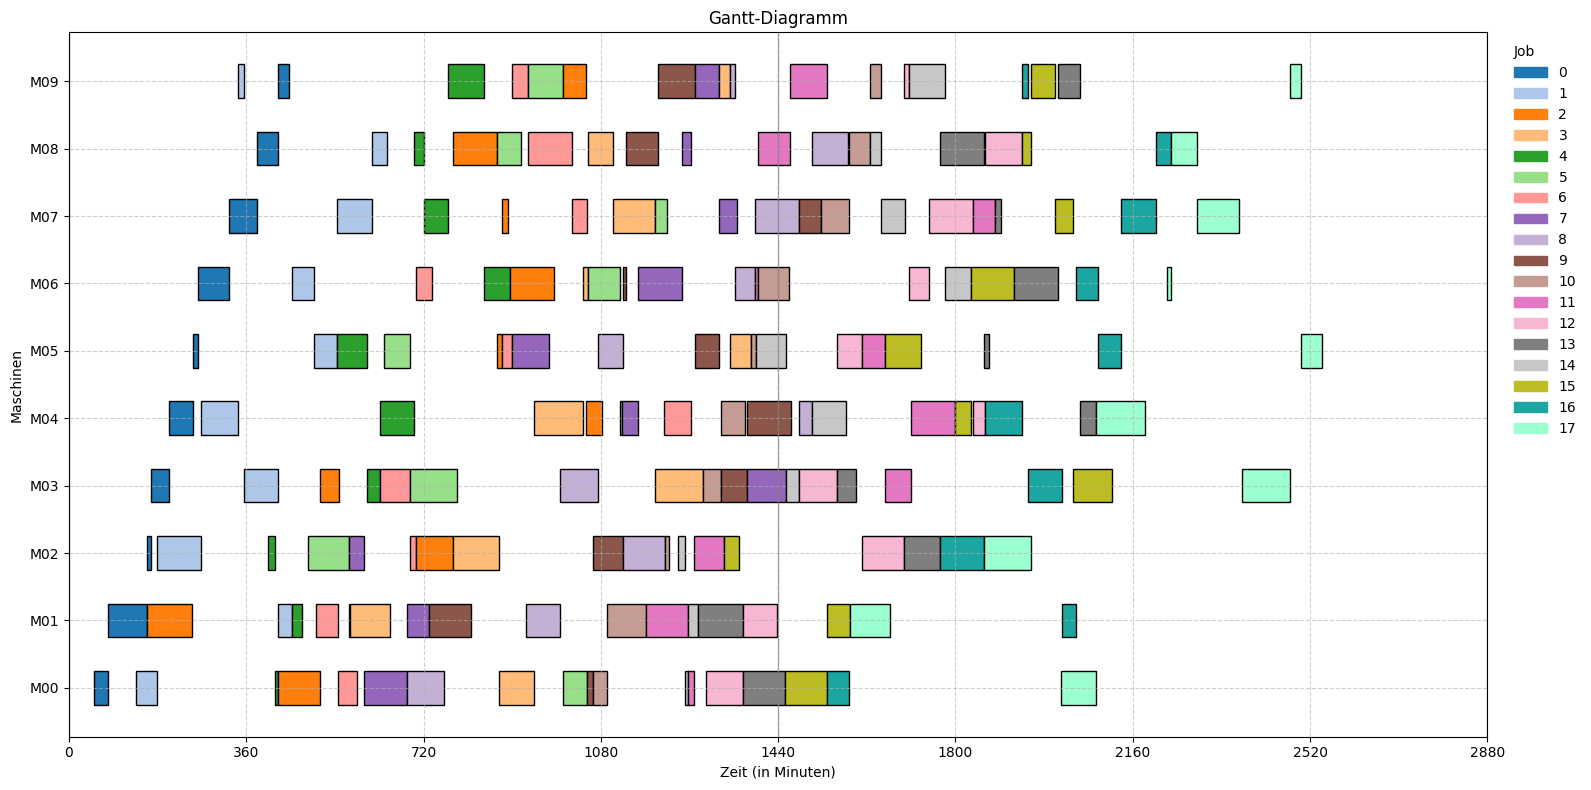

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## II) Erster Tag (Tag 0)

### a) Simulation

In [8]:
day_length = 1440

In [9]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [10]:
simulation = ProductionDaySimulation(df_schedule, vc=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[00:51:00] Job 0 started on M00
[01:22:55] Job 0 finished on M00 (after 31 minutes 56 seconds)
[01:22:55] Job 0 started on M01
[02:16:00] Job 1 started on M00
[02:39:24] Job 0 finished on M01 (after 76 minutes 28 seconds)
[02:39:24] Job 2 started on M01
[02:39:24] Job 0 started on M02
[02:50:12] Job 0 finished on M02 (after 10 minutes 49 seconds)
[02:50:12] Job 0 started on M03
[03:02:55] Job 1 finished on M00 (after 46 minutes 56 seconds)
[03:02:55] Job 1 started on M02
[03:49:03] Job 0 finished on M03 (after 58 minutes 51 seconds)
[03:49:03] Job 0 started on M04
[04:26:36] Job 0 finished on M04 (after 37 minutes 32 seconds)
[04:26:36] Job 0 started on M05
[04:36:46] Job 0 finished on M05 (after 10 minutes 10 seconds)
[04:36:46] Job 0 started on M06
[04:44:35] Job 2 finished on M01 (after 125 minutes 11 seconds)
[04:56:30] Job 1 finished on M02 (after 113 minutes 35 seconds)
[04:56:30] Job 1 started on M04
[06:12:55] Job 1 finished on M04 (after 76 minutes 25 seconds)
[06:12:55] Job 1

In [11]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,7,7,9,528,1516.0,M03,1376.0,79.0,1455.0,0
1,9,9,8,559,1549.0,M04,1376.0,90.0,1466.0,0
2,8,8,7,550,1644.0,M07,1393.0,89.0,1482.0,0
3,14,4,3,1177,1898.0,M05,1396.0,61.0,1457.0,0
4,10,0,6,963,1687.0,M06,1400.0,62.0,1462.0,0
...,...,...,...,...,...,...,...,...,...,...
63,17,3,5,1343,2544.0,M08,2238.0,52.0,2290.0,0
64,17,3,6,1343,2544.0,M07,2290.0,85.0,2375.0,0
65,17,3,7,1343,2544.0,M03,2381.0,98.0,2479.0,0
66,17,3,8,1343,2544.0,M09,2479.0,22.0,2501.0,0


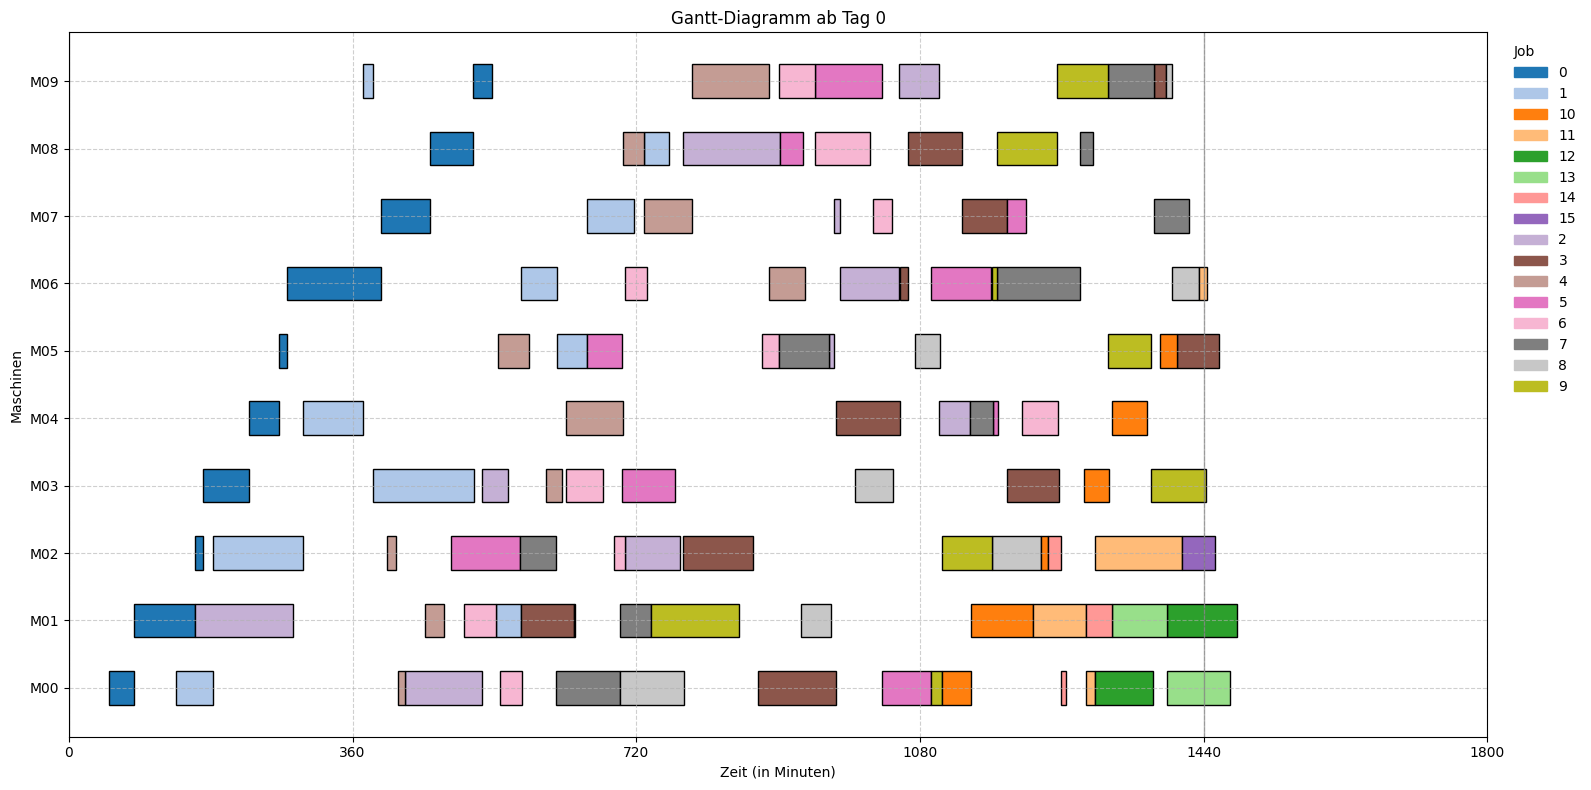

In [12]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [13]:
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,7,7,9,528,1516.0,M03,1376.0,79.0,1455.0,0
1,9,9,8,559,1549.0,M04,1376.0,90.0,1466.0,0
2,8,8,7,550,1644.0,M07,1393.0,89.0,1482.0,0
3,14,4,3,1177,1898.0,M05,1396.0,61.0,1457.0,0
4,10,0,6,963,1687.0,M06,1400.0,62.0,1462.0,0
...,...,...,...,...,...,...,...,...,...,...
63,17,3,5,1343,2544.0,M08,2238.0,52.0,2290.0,0
64,17,3,6,1343,2544.0,M07,2290.0,85.0,2375.0,0
65,17,3,7,1343,2544.0,M03,2381.0,98.0,2479.0,0
66,17,3,8,1343,2544.0,M09,2479.0,22.0,2501.0,0


In [14]:
df_job_times_undone = process_filter.update_times_after_operation_changes(df_job_times, df_plan_undone)
df_job_times_undone

,Job,Production_Plan_ID,Arrival,Deadline
0,7,7,528,1516.0
1,8,8,550,1644.0
2,9,9,559,1549.0
3,10,0,963,1687.0
4,11,9,969,1959.0
5,12,8,992,2086.0
6,13,2,1046,2087.0
7,14,4,1177,1898.0
8,15,7,1193,2181.0
9,16,1,1310,2245.0


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [15]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
39,3,3,9,M05,236,1406.19,53.69,1459.88
93,9,9,7,M03,559,1373.51,69.61,1443.12
103,11,9,3,M06,969,1433.97,10.90,1444.87
105,12,8,1,M01,992,1393.85,88.12,1481.97
107,13,2,1,M00,1046,1393.85,79.63,1473.48
111,15,7,0,M02,1193,1412.75,41.78,1454.53


In [23]:
df_reschedule = lp_tard_reschedule.solve_jssp_sum_with_fixed_ops(df_plan_undone, df_job_times_undone,
                                                                 df_execution_important,
                                                                 reschedule_start = 1440,
                                                                 solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_reschedule

BigM: 4000

Solver-Informationen:
  Summe Tardiness         : 65.8
  Solver-Status           : Optimal
  Anzahl Variablen        : 349
  Anzahl Constraints      : 608
  Laufzeit                : ~1 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,8,8,7,550,1644.0,M07,1440.00,89.0,1529.00,0.00
1,7,7,9,528,1516.0,M03,1443.12,79.0,1522.12,6.12
2,9,9,8,559,1549.0,M04,1443.12,90.0,1533.12,0.00
3,10,0,6,963,1687.0,M06,1444.87,62.0,1506.87,0.00
4,11,9,4,969,1959.0,M08,1444.87,64.0,1508.87,0.00
...,...,...,...,...,...,...,...,...,...,...
63,17,3,5,1343,2544.0,M08,2245.48,52.0,2297.48,0.00
64,17,3,6,1343,2544.0,M07,2297.48,85.0,2382.48,0.00
65,17,3,7,1343,2544.0,M03,2382.48,98.0,2480.48,0.00
66,17,3,8,1343,2544.0,M09,2480.48,22.0,2502.48,0.00


In [29]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            5
0 - 60       6
60 - 120     0
120 - 180    0
>180         0
Name: count, dtype: int64


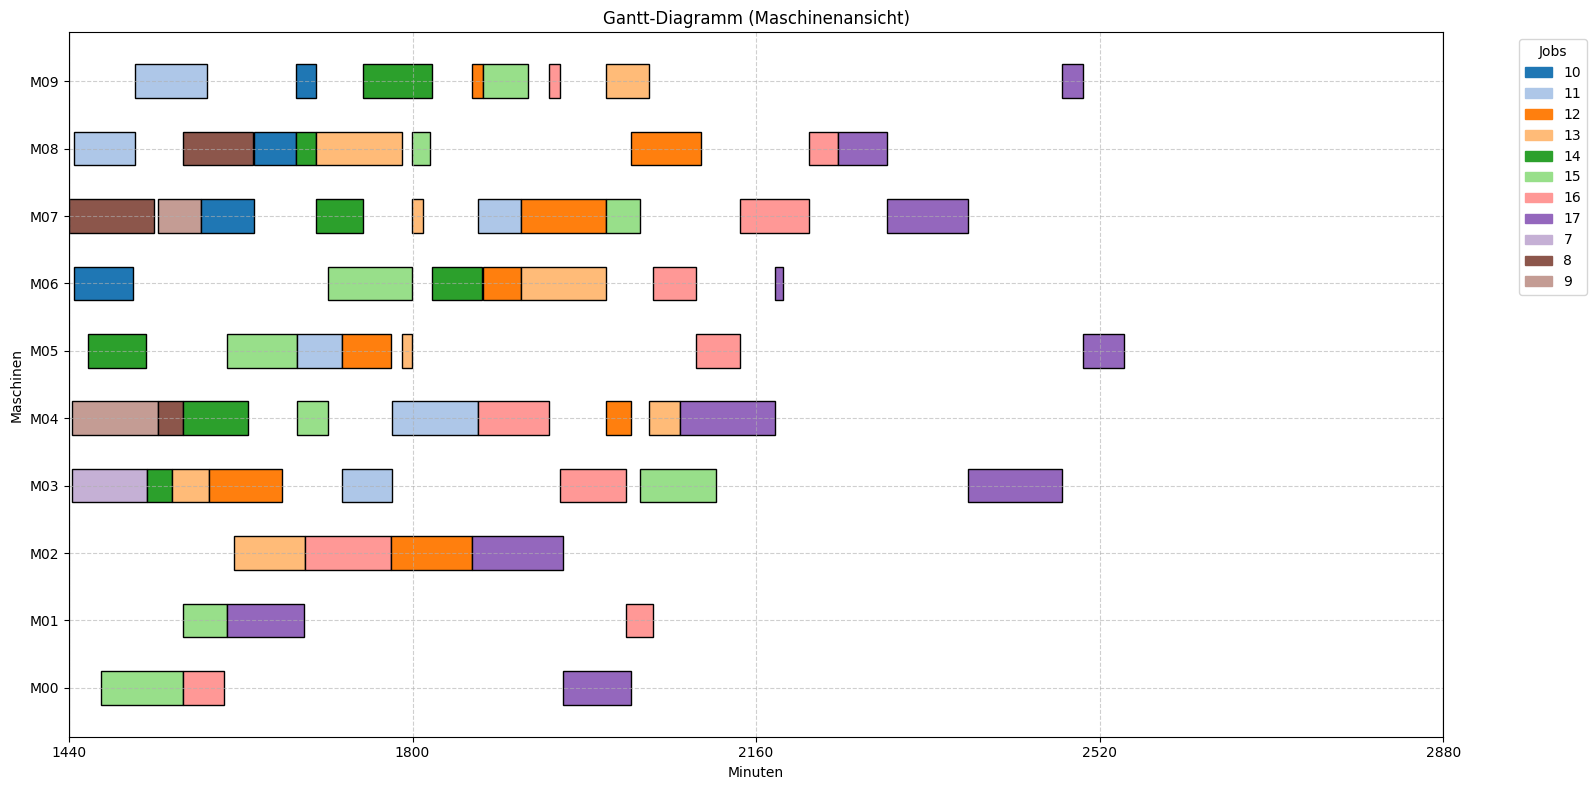

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [25]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

## Simulation + neuer Schedule 

In [26]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End,Deadline,Tardiness
0,0,0,0,M00,51,51.00,31.93,82.93,NaN,NaN
1,0,0,1,M01,51,82.93,76.47,159.40,NaN,NaN
2,0,0,2,M02,51,159.40,10.81,170.21,NaN,NaN
3,0,0,3,M03,51,170.21,58.85,229.06,NaN,NaN
4,0,0,4,M04,51,229.06,37.54,266.60,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
175,17,3,5,M08,1343,2245.48,52.00,2297.48,2544.0,0.00
176,17,3,6,M07,1343,2297.48,85.00,2382.48,2544.0,0.00
177,17,3,7,M03,1343,2382.48,98.00,2480.48,2544.0,0.00
178,17,3,8,M09,1343,2480.48,22.00,2502.48,2544.0,0.00


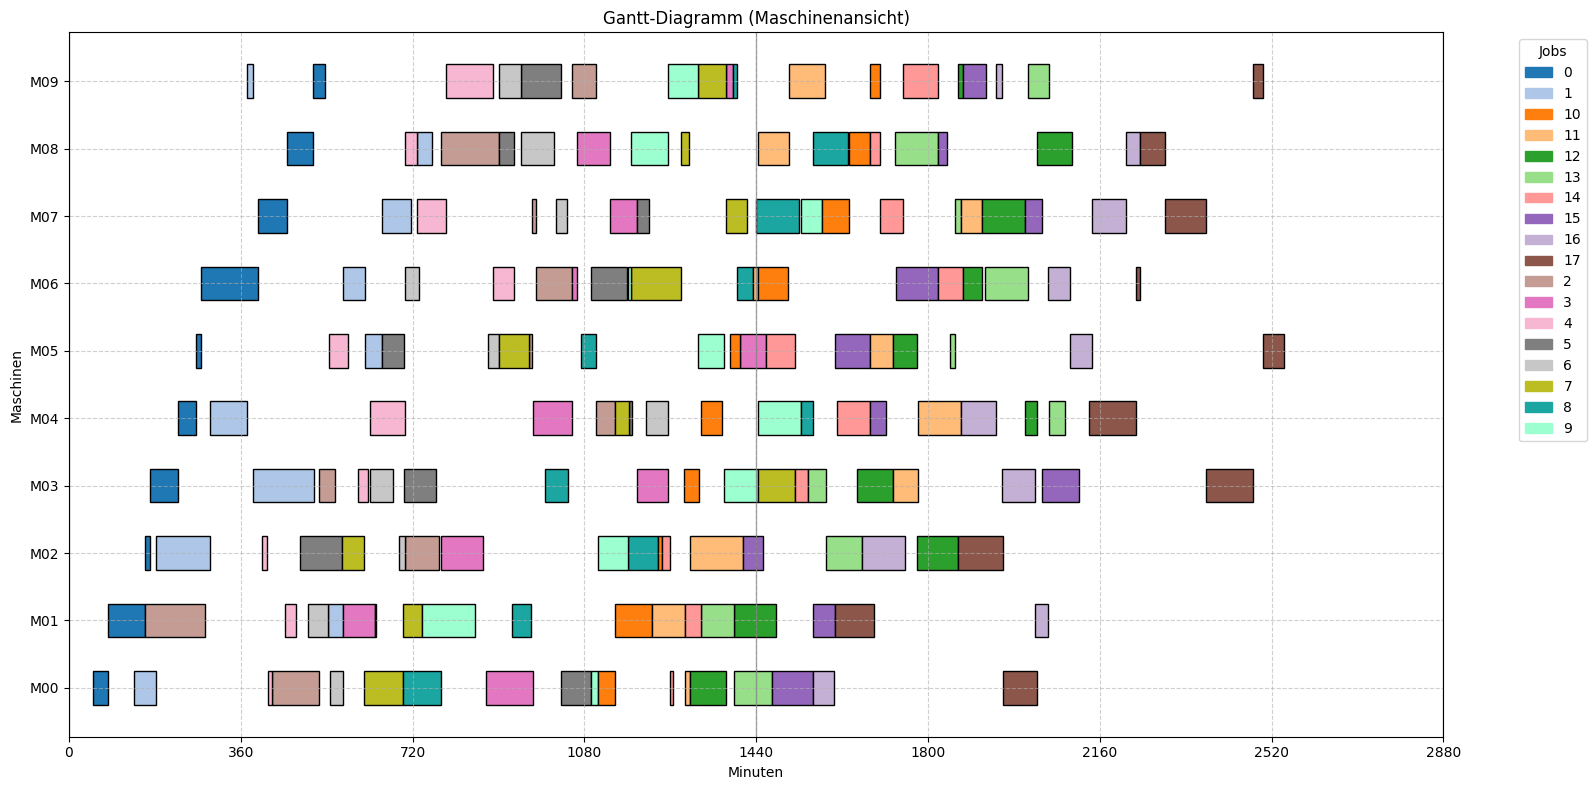

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)